In [1]:
import glob
import cv2
import numpy as np
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import random

In [2]:
# シードを固定する関数
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# シードを固定
set_seed(42)

In [3]:
def make_models(model_paths):
        
    class DeepAutoencoder(nn.Module):
        def __init__(self):
            super(DeepAutoencoder, self).__init__()
            self.Encoder = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 256 -> 128
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 128 -> 64
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 64 -> 32
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 32 -> 16
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 16 -> 8
            )
            self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 -> 64
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 64 -> 128
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # 128 -> 256
                nn.ReLU(),
                nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            )

        def forward(self, x):
            x = self.Encoder(x)
            x = self.Decoder(x)
            return x
    
    models = []
    for model_path in model_paths:
        model = DeepAutoencoder().cuda()
        model.load_state_dict(torch.load(model_path))
        models.append(model)
    return models

In [4]:
# 画像分割サイズ
distance = 224

# 画像を分割する関数
def split(FILES):
    # 分割後の画像を分割前の画像ごとに格納
    split_images = []
    for i in range(len(FILES)):
        file = FILES[i]  # ファイル名
        img = Image.open(file)  # 画像読み込み
        img = np.array(img)  # Pillowの画像をnumpy配列に変換
        h, w = img.shape[:2]  # 画像のサイズ
        # 分割の始点
        cx = 0
        cy = 0
        for x in range(h // distance):
            for y in range(w // distance):
                # 画像の切り取り
                split_img = img[cx:cx + distance, cy:cy + distance]
                # 画像の格納
                split_images.append(Image.fromarray(split_img))  # numpy配列をPillowの画像に変換して格納
                cy += distance
            cy = 0
            cx += distance
    return split_images

In [ ]:
def AE(IMGS, model_paths):
    models = make_models(model_paths)

    preprocess = T.Compose([T.ToTensor()])
    diff_lists = {os.path.basename(model_path): [] for model_path in model_paths}

    for IMG in IMGS:
        for model_idx, model in enumerate(models):
            model.eval()
            model_name = os.path.basename(model_paths[model_idx])

            img_tensor = preprocess(IMG).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(img_tensor)[0]
            output = output.cpu().numpy().transpose(1, 2, 0)
            output = np.uint8(np.maximum(np.minimum(output * 255, 255), 0))
            origin = np.uint8(img_tensor[0].cpu().numpy().transpose(1, 2, 0) * 255)
            diff_mse = np.uint8((output.astype(np.float32) - origin.astype(np.float32)) ** 2)
            diff_mse = np.sum(diff_mse)
            diff_mse_sum = diff_mse / (224 * 224 * 3)
            diff_lists[model_name].append(diff_mse_sum)

    avg_mse = {model_name: np.mean(diff_list) for model_name, diff_list in diff_lists.items()}
    return avg_mse

In [11]:
model_paths_d = ["models/fine_model_paths/6048_fineAEdeepmodel_20241226_ddark.pth","models/fine_model_paths/6048_fineAEdeepmodel_20241226_dlight.pth","models/fine_model_paths/6048_fineAEdeepmodel_20241226_dwhite.pth"]
model_paths_r = ["models/fine_model_paths/6048_fineAEdeepmodel_20241226_rdark.pth","models/fine_model_paths/6048_fineAEdeepmodel_20241226_rlight.pth","models/fine_model_paths/6048_fineAEdeepmodel_20241226_rwhite.pth"]
model_paths = model_paths_d + model_paths_r
threshold = 128
files = list(glob.glob("imgs/test_img/*"))
split_images = split(files)
avg_mse = AE(split_images, model_paths)

/tmp/ipykernel_1408792/309347958.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


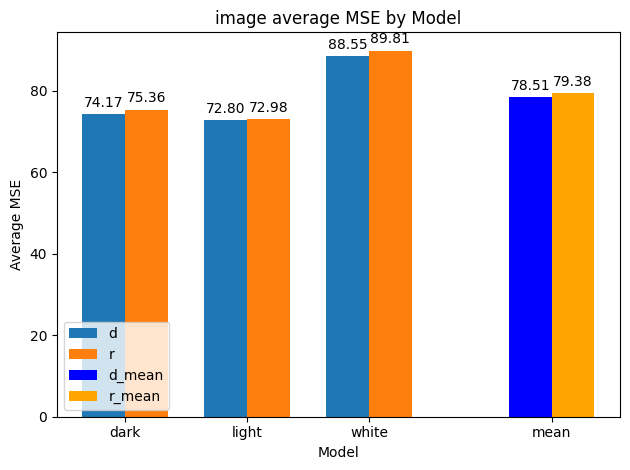

In [12]:
# データを整理
labels = ['dark', 'light', 'white']
d_values = [avg_mse[f'6048_fineAEdeepmodel_20241226_d{label}.pth'] for label in labels]
r_values = [avg_mse[f'6048_fineAEdeepmodel_20241226_r{label}.pth'] for label in labels]

# 平均値を計算
d_mean = np.mean(d_values)
r_mean = np.mean(r_values)

# 棒グラフの作成
x = np.arange(len(labels))  # ラベルの位置
width = 0.35  # 棒の幅

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, d_values, width, label='d')
rects2 = ax.bar(x + width/2, r_values, width, label='r')

# 平均値の棒グラフを追加
rects3 = ax.bar(len(labels) + 0.5 - width/2, d_mean, width, label='d_mean', color='blue')
rects4 = ax.bar(len(labels) + 0.5 + width/2, r_mean, width, label='r_mean', color='orange')

# グラフのラベルとタイトルを設定
ax.set_xlabel('Model')
ax.set_ylabel('Average MSE')
ax.set_title('image average MSE by Model')
ax.set_xticks(np.append(x, len(labels) + 0.5))
ax.set_xticklabels(labels + ['mean'])
ax.legend()

# 棒グラフに値を表示
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

In [8]:
import os
import glob
import random
import shutil

def copy_random_images(src_dir, dest_dir, num_images):
    # すべてのサブフォルダを取得
    subdirs = [d for d in glob.glob(os.path.join(src_dir, '*')) if os.path.isdir(d)]
    for subdir in subdirs:
        # サブフォルダ名を取得
        subdir_name = os.path.basename(subdir)
        # すべての画像ファイルを取得
        image_files = glob.glob(os.path.join(subdir, '*.jpg'))
        # ランダムに選択
        selected_files = random.sample(image_files, min(num_images, len(image_files)))
        # コピー先のサブフォルダを作成
        dest_subdir = os.path.join(dest_dir, subdir_name)
        os.makedirs(dest_subdir, exist_ok=True)
        # 画像をコピー
        for file in selected_files:
            shutil.copy(file, dest_subdir)

def create_mixed_dataset(src_base_dir, dest_base_dir, *args):
    for arg in args:
        if isinstance(arg, int):
            # 単一の数値の場合
            parent_dir = os.path.join(dest_base_dir, f'train_img_{arg}')
            dest_dir = os.path.join(parent_dir, str(arg))
            copy_random_images(src_base_dir, dest_dir, arg)
        elif isinstance(arg, tuple):
            # 複数の数値の場合
            parent_dir = os.path.join(dest_base_dir, f'train_img_{"_".join(map(str, arg))}')
            for num_images in arg:
                dest_dir = os.path.join(parent_dir, str(num_images))
                copy_random_images(src_base_dir, dest_dir, num_images)

In [9]:
src_base_dir = 'imgs/update_train_imgs_remove/train_img_6048/6048'
dest_base_dir = 'imgs/update_train_imgs_remove_mix'


create_mixed_dataset(src_base_dir, dest_base_dir, 100)

create_mixed_dataset(src_base_dir, dest_base_dir, 1000)

create_mixed_dataset(src_base_dir, dest_base_dir, (2000, 3000))

create_mixed_dataset(src_base_dir, dest_base_dir, (4000, 5000))

In [10]:
src_base_dir = 'imgs/update_train_imgs_default/train_img_6048/6048'
dest_base_dir = 'imgs/update_train_imgs_default_mix'


create_mixed_dataset(src_base_dir, dest_base_dir, 100)

create_mixed_dataset(src_base_dir, dest_base_dir, 1000)

create_mixed_dataset(src_base_dir, dest_base_dir, (2000, 3000))

create_mixed_dataset(src_base_dir, dest_base_dir, (4000, 5000))